In [1]:
import sys
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Local
cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))

from utils.utils import count_parameters, create_sequence
from utils.train import train_and_validate
from utils.watertopo import WaterTopo

# Important for animation to run inline
%matplotlib inline
%matplotlib ipympl

In [2]:
#initialize GPU -  In case of windows use cuda instead of nps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA enabled?",torch.cuda.is_available())
print("Number of GPUs",torch.cuda.device_count())
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Is CUDA enabled? False
Number of GPUs 0
Using device: cpu


In [3]:
from models.unet_mask import UNet_mask
model = UNet_mask(2, [32, 64], 1, 5, bilinear=False).to(device)

print(f"U-Net --> num. trainable parameters:{count_parameters(model):8d}")

U-Net --> num. trainable parameters:  101505


In [4]:
train = False   # Train = True/False depending on whether the model has been trained yet.

In [5]:
sim_amount = 1
use_augmented_data = False
T = 1
H = 1
skips = 5
training_size = 0.8
batch_size = 5
num_epochs = 20
lr = 0.0005
criterion = nn.MSELoss()
optimizer = optim.AdamW
model_name = "unet_32_64_orig_data80_skip5_hardmask5"

# defining the save path
save_path = "../results/trained_models/unet_mask/" + model_name

In [6]:
if train:
    sims = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val", sim_amount=sim_amount, number_grids=64, use_augmented_data=use_augmented_data)

    X, Y = create_sequence(sims, T, H, skips)
    X, Y = X.squeeze(1), Y.squeeze(1)

    # We keep track of indexes of train and validation.
    X_tra, X_tst, Y_tra, Y_tst, ix_tra, ix_tst = train_test_split(
        X, Y, np.arange(X.shape[0]), test_size=1-training_size, shuffle=True, random_state=42)

    # Split the existing test dataset into validation and test sets (50/50 split)
    X_val, X_tst, Y_val, Y_tst, ix_val, ix_tst = train_test_split(
        X_tst, Y_tst, ix_tst, test_size=0.5, shuffle=True, random_state=42)

    #create datasets and data loaders
    train_dataset = TensorDataset(torch.tensor(X_tra, dtype=torch.float32), torch.tensor(Y_tra, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # defining the optimizer
    optimizer = optimizer(model.parameters(), lr=lr)

    # training
    train_losses, val_losses, best_val_loss, time = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path)

# Load the best model
model.load_state_dict(torch.load(save_path, map_location="cpu"))

<All keys matched successfully>

In [7]:
print(model.distance)

5


In [8]:
if train:
    plt.plot(train_losses, label='Training')
    plt.plot(val_losses, label='Validation')
    # plt.yscale('log')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

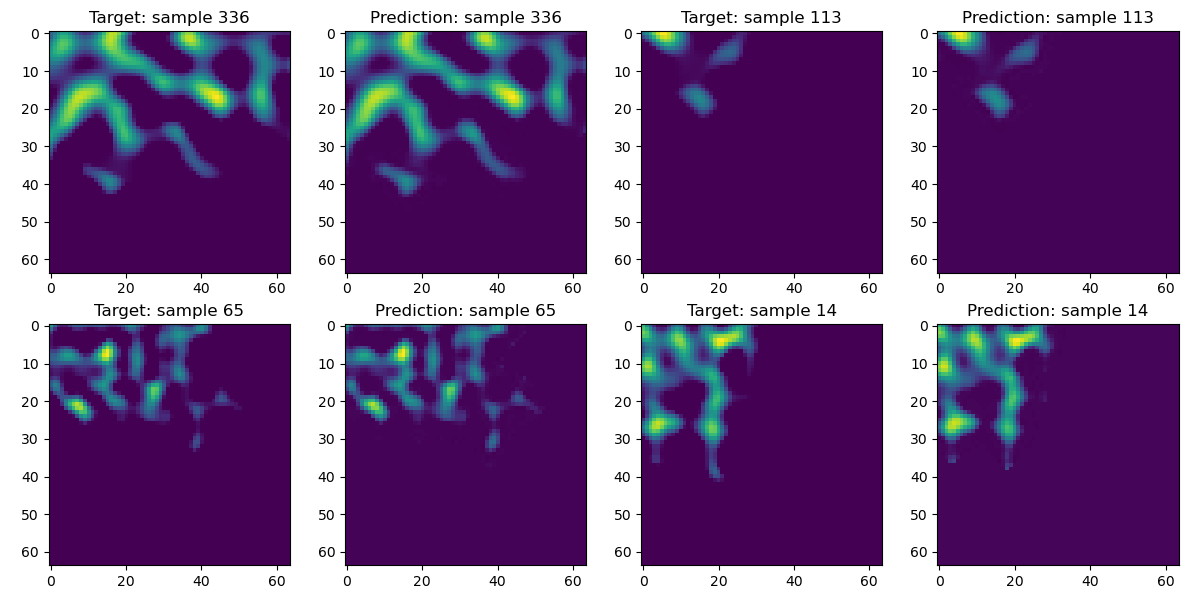

In [9]:
model.eval()

grid_size = 64
channels = 2
sim_amount = 4

f,axs = plt.subplots(2, 4, figsize=(12,6))
axs = axs.reshape(-1)

for i in range(0, len(axs), 2):
  with torch.no_grad():

      sims = WaterTopo.load_simulations(str(root)+"/data/normalized_data/test1",
                                        sim_amount=sim_amount, number_grids=64,
                                        use_augmented_data=True)   # use_augmented_data = True because test data is not loaded correctly otherwise

      X, Y = create_sequence(sims, T, H, skip=skips)
      X, Y = X.squeeze(1), Y.squeeze(1)

      # Randomly select a simulation
      idx = random.randint(0, X.shape[0]-1)
      inputs = X[idx]
      targets = Y[idx]

      # Predict
      inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
      inputs = inputs.unsqueeze(0)
      prediction = model(inputs).cpu()

      # Plotting inputs (time series)
      axs[i].imshow(targets.reshape([64, 64, 1]))
      axs[i+1].imshow(prediction.reshape([64, 64, 1]))

      axs[i].set_title(f"Target: sample {idx}")
      axs[i+1].set_title(f"Prediction: sample {idx}")

f.tight_layout()

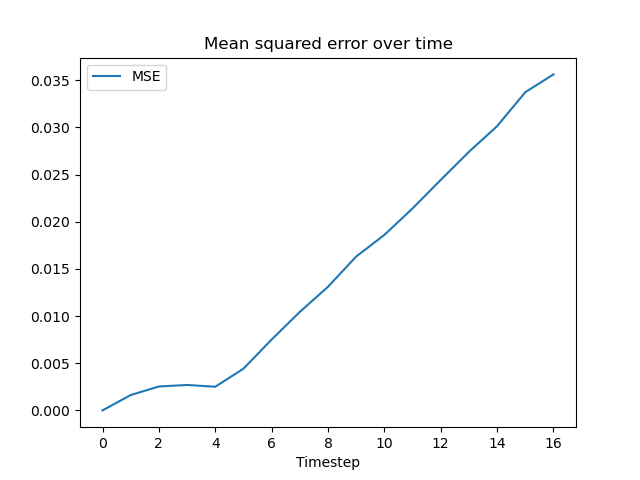

In [10]:
grid_size = 64

from utils.utils import recursive_pred
from utils.utils import mse_per_timestep

sim = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val", 1, grid_size, False)[0]
sim = sim.implement_skips(skips)

with torch.no_grad():
    topo = sim.topography.reshape([1, grid_size, grid_size])
    wd = sim.wd
    wd_0 = sim.wd[0].reshape([1, grid_size, grid_size])
    X = np.concatenate([topo, wd_0])

    outputs = recursive_pred(model, X, sim.wd.shape[0]-1, include_first_timestep=True)
    mse = mse_per_timestep(sim.wd, outputs)

    plt.figure()
    plt.plot(mse, label='MSE')
    plt.title('Mean squared error over time')
    plt.xlabel('Timestep')
    plt.legend()
    plt.show()

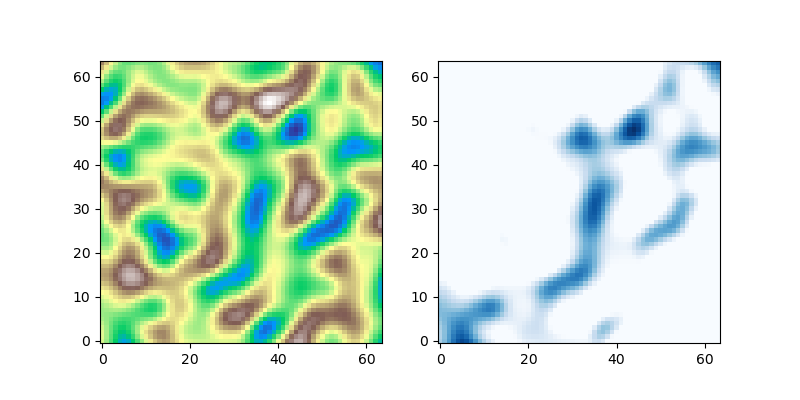

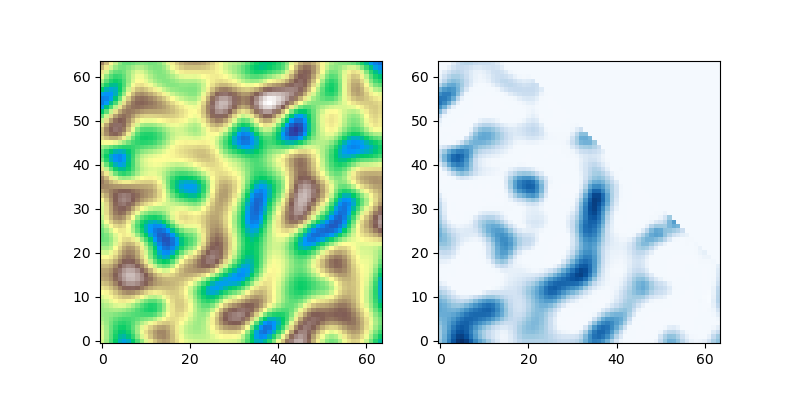

In [11]:
sim_model = WaterTopo(sim.topography, outputs)
anim1 = sim.plot_animation()
anim2 = sim_model.plot_animation()

In [12]:
wd_pred = sim_model.wd.detach().numpy()
wd = sim.wd
Z = sim_model.topography

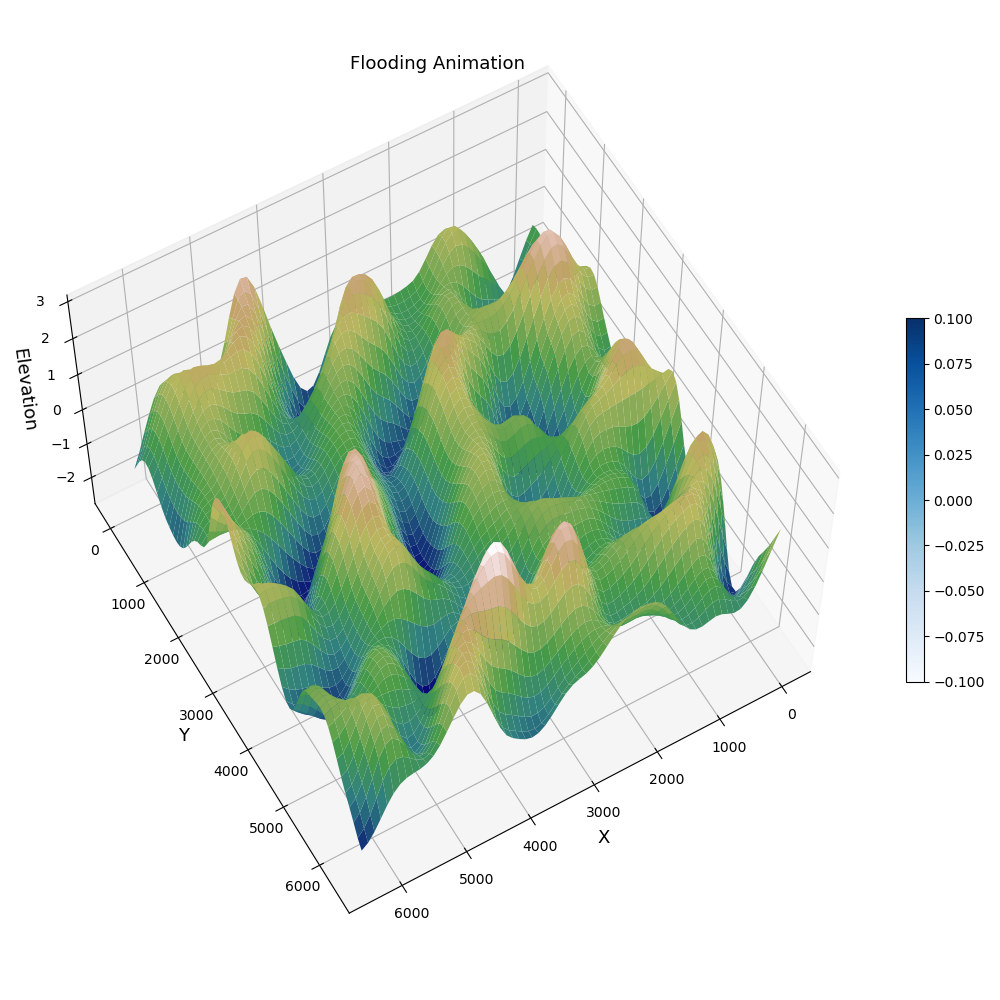

done


In [13]:
from utils.flow_animation import animation_create
from matplotlib import cm

nx, ny = (64,64)
x = np.linspace(0,6350, nx)
y = np.linspace(0,6350, ny)
xv, yv = np.meshgrid(x,y)
path = str(src) + "/animations/Flooding Animation Final.gif"

animation_create(savepath=path,X =xv,Y = yv, Z = Z,wd = wd_pred, N = 64,fps = 10, color_dem=cm.gist_earth, mask_threshold=0)

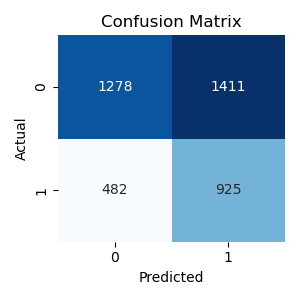

Confusion Matrix:
 [[1278 1411]
 [ 482  925]]
Accuracy: 0.5378
Recall: 0.6574
Precision: 0.3960
F1 Score: 0.4943


In [14]:
from utils.performance import confusionmatrix

confusionmatrix(wd_pred,wd,-1)

Creating an animation with gif


C:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\Q2\Unit 3\DS-AI\src\utils\performance.py:38: RuntimeWarning: invalid value encountered in divide
  acc = 1-np.divide(abs((prediction[i] - Real[i])),Real[i])
C:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\Q2\Unit 3\DS-AI\src\utils\performance.py:38: RuntimeWarning: divide by zero encountered in divide
  acc = 1-np.divide(abs((prediction[i] - Real[i])),Real[i])


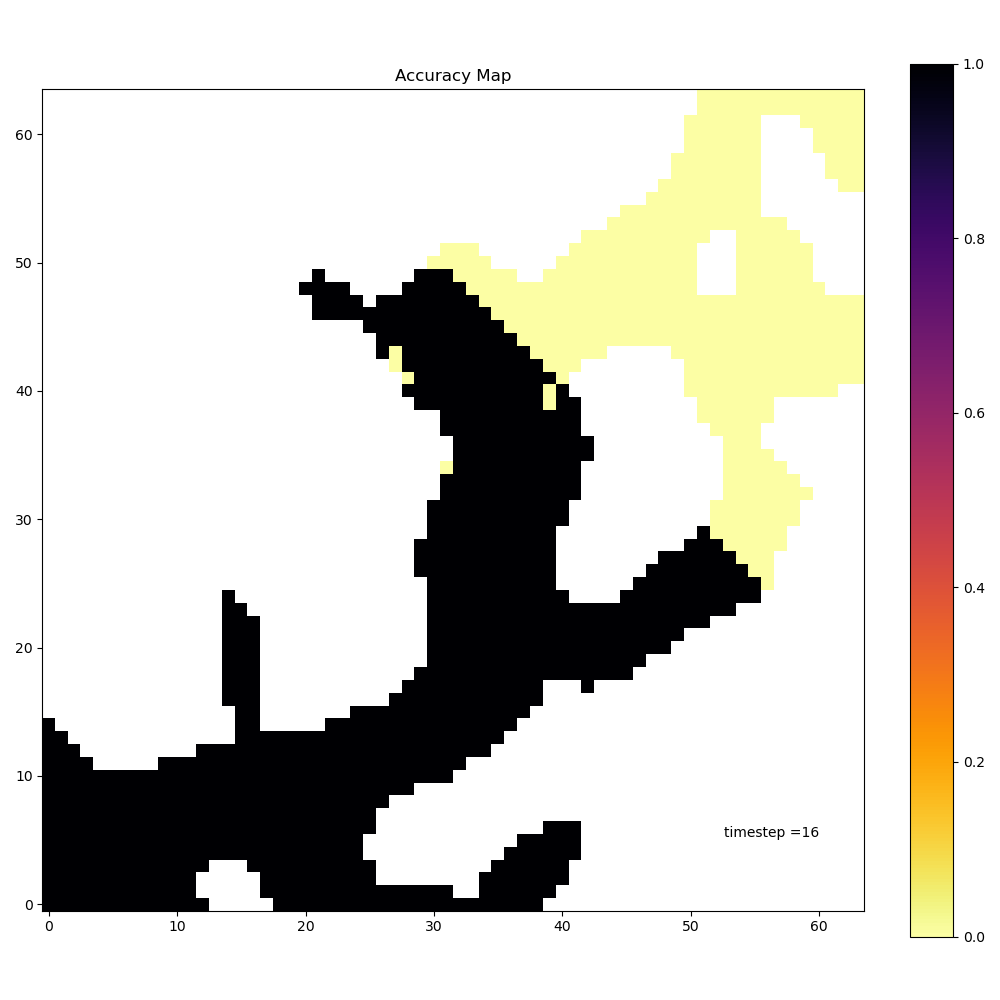

done


In [15]:
from utils.performance import performance
save_path_accuracy = "../animations" + "/accuracy1.gif"
performance(wd_pred, wd, 'animation', save_path = save_path_accuracy)